Enter the number of configurations to test: 10
Config 1: {'manufacturing_reduction': 0, 'distribution_reduction': 0}, Average Time: 10.54, Average Cost: 16684.3344


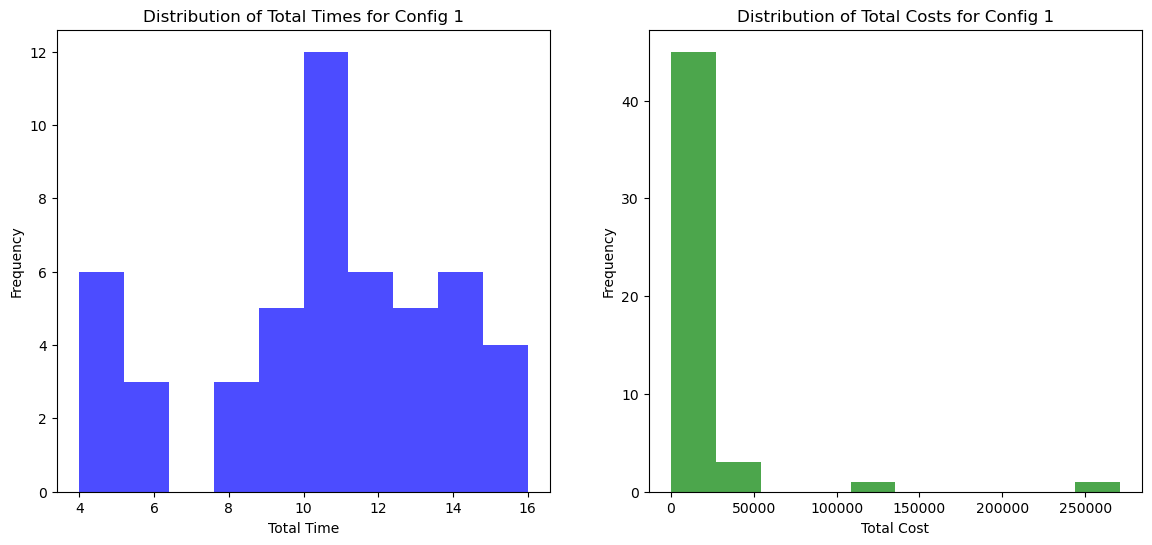

Config 2: {'manufacturing_reduction': 1, 'distribution_reduction': 0}, Average Time: 9.84, Average Cost: 14368.1778


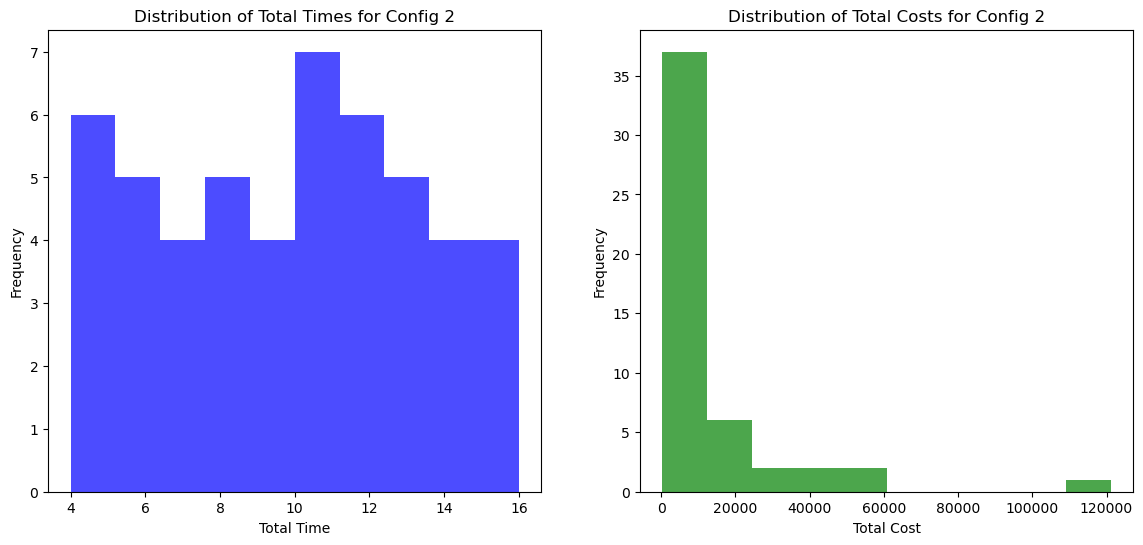

Config 3: {'manufacturing_reduction': 2, 'distribution_reduction': 1}, Average Time: 8.92, Average Cost: 24073.738100000006


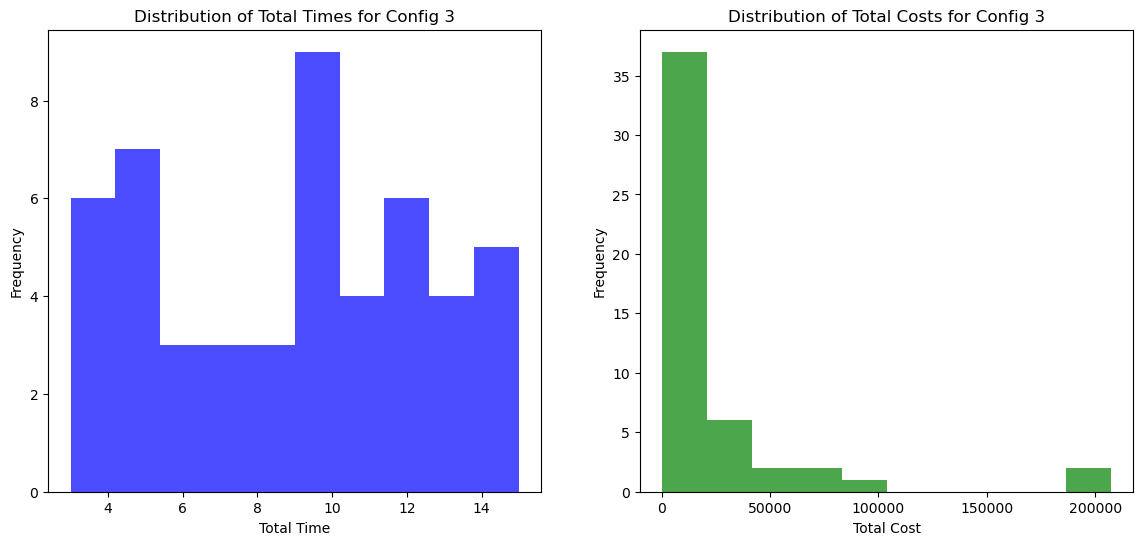

Config 4: {'manufacturing_reduction': 3, 'distribution_reduction': 1}, Average Time: 6.94, Average Cost: 9798.044200000002


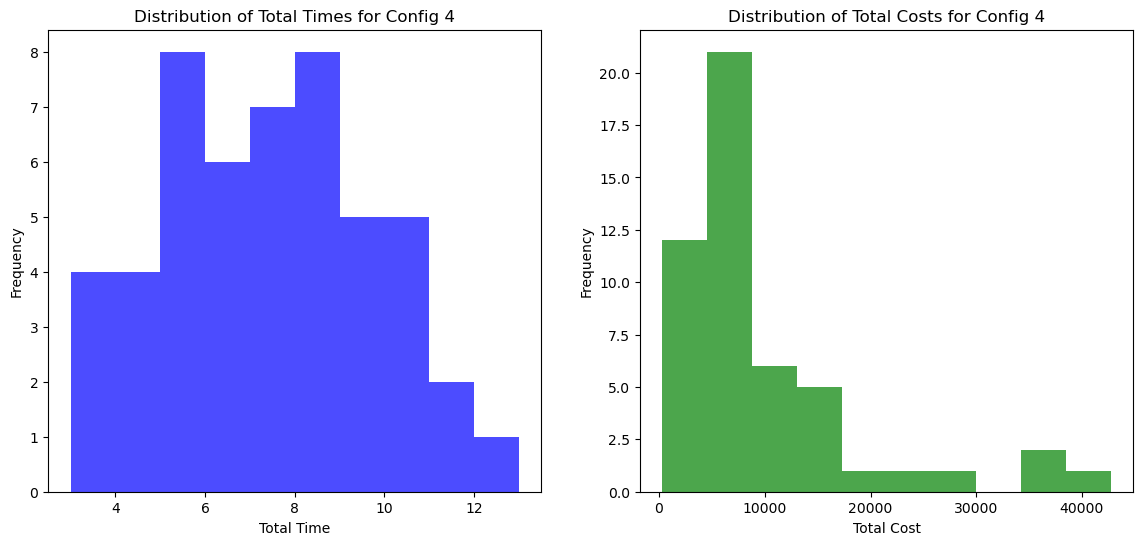

Config 5: {'manufacturing_reduction': 4, 'distribution_reduction': 2}, Average Time: 6.04, Average Cost: 12752.4022


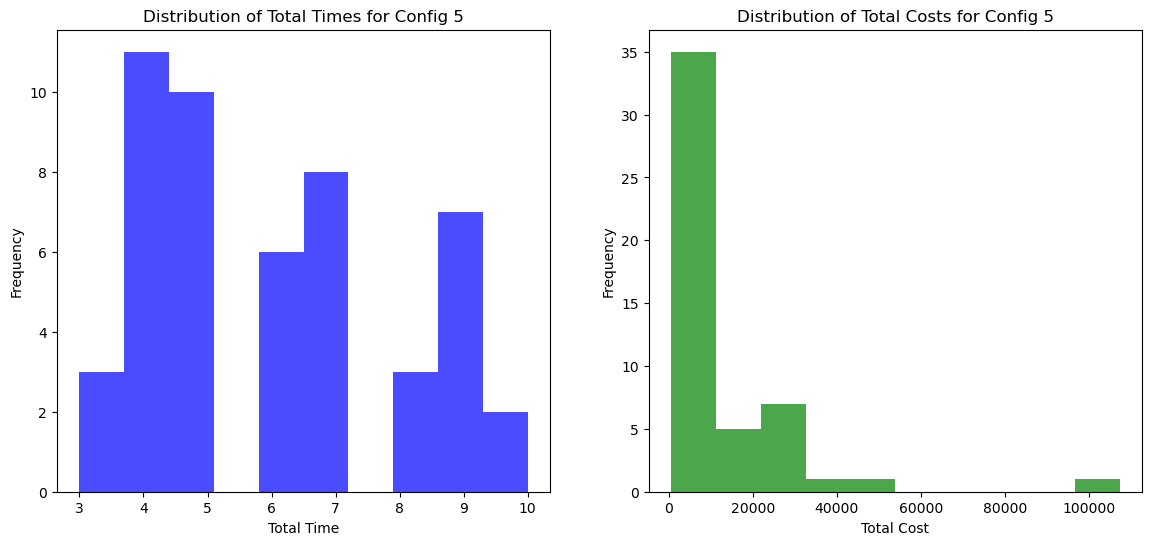

Config 6: {'manufacturing_reduction': 5, 'distribution_reduction': 2}, Average Time: 5.26, Average Cost: 11295.4114


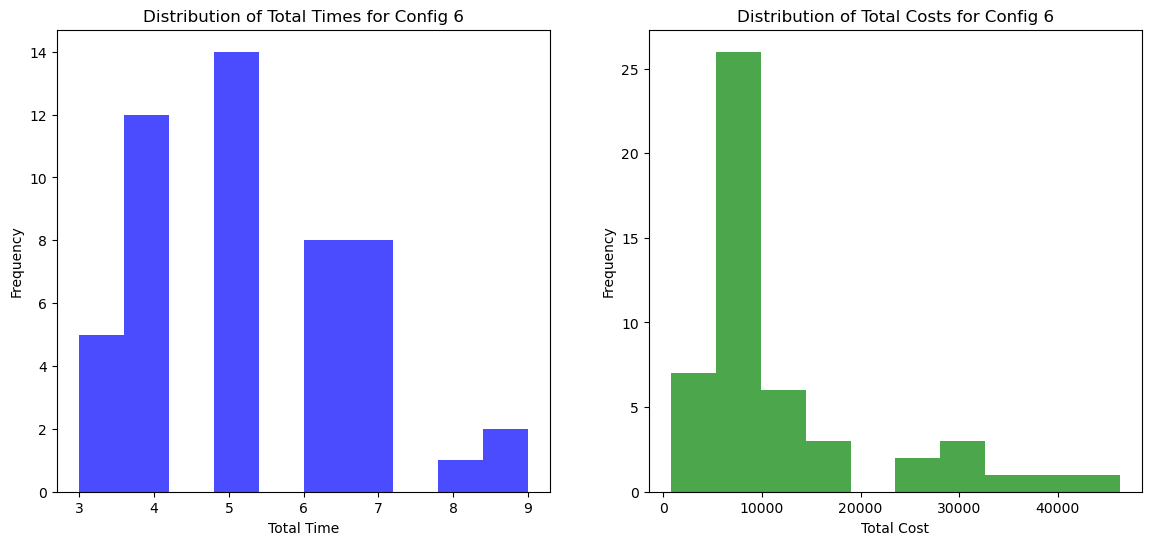

Config 7: {'manufacturing_reduction': 6, 'distribution_reduction': 3}, Average Time: 4.86, Average Cost: 12034.465400000001


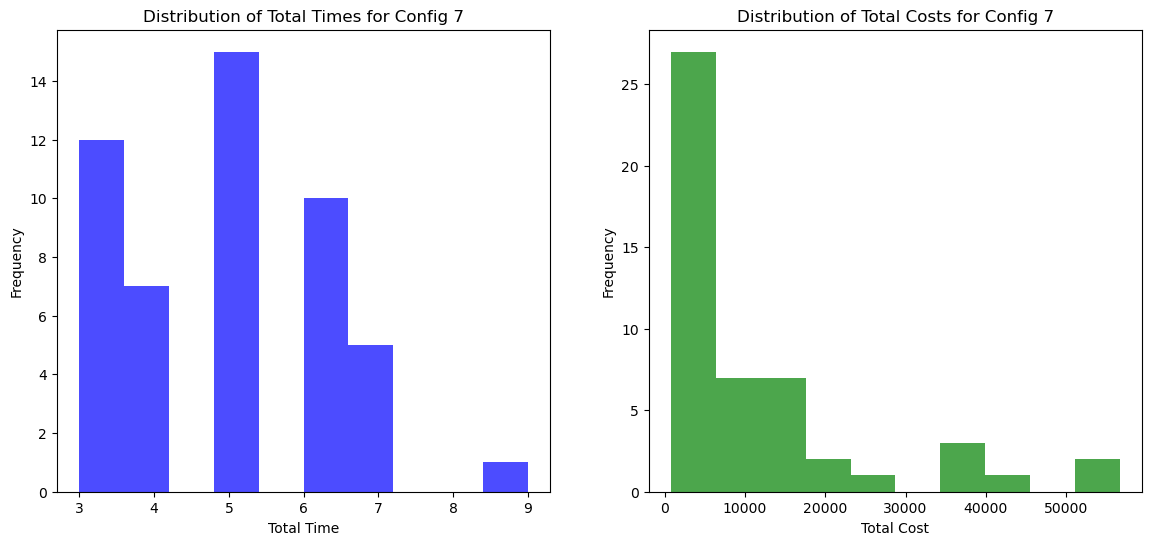

Config 8: {'manufacturing_reduction': 7, 'distribution_reduction': 3}, Average Time: 4.72, Average Cost: 10930.8475


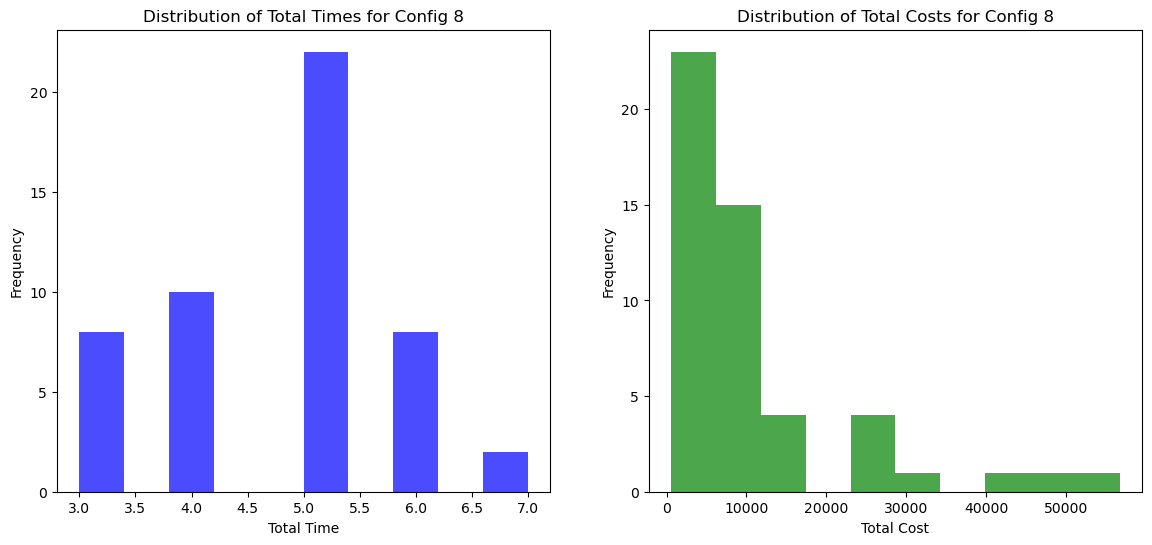

Config 9: {'manufacturing_reduction': 8, 'distribution_reduction': 4}, Average Time: 4.06, Average Cost: 9500.538400000001


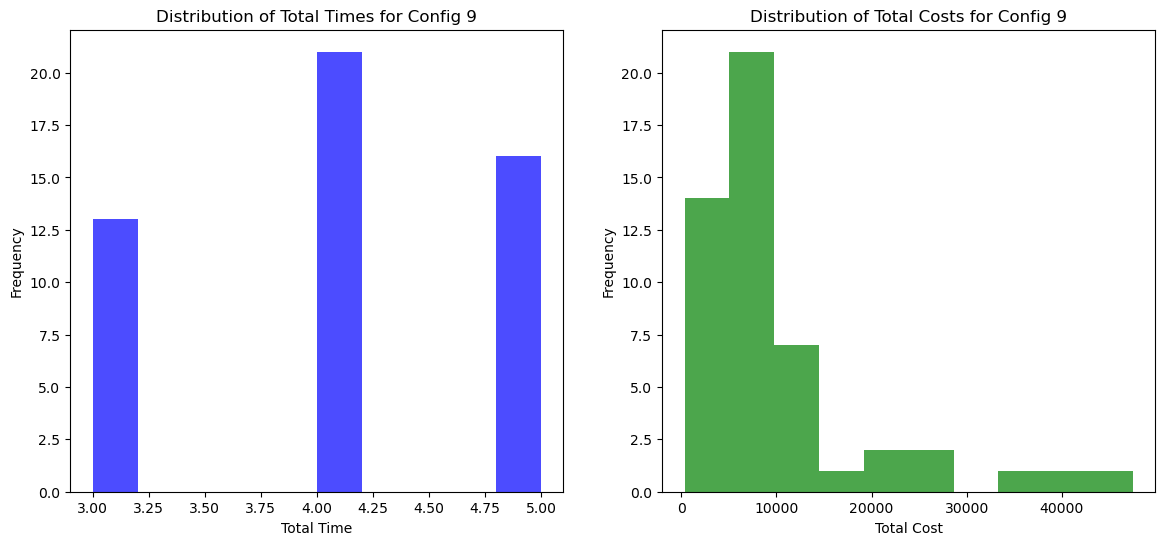

Config 10: {'manufacturing_reduction': 9, 'distribution_reduction': 4}, Average Time: 3.98, Average Cost: 9478.387800000002


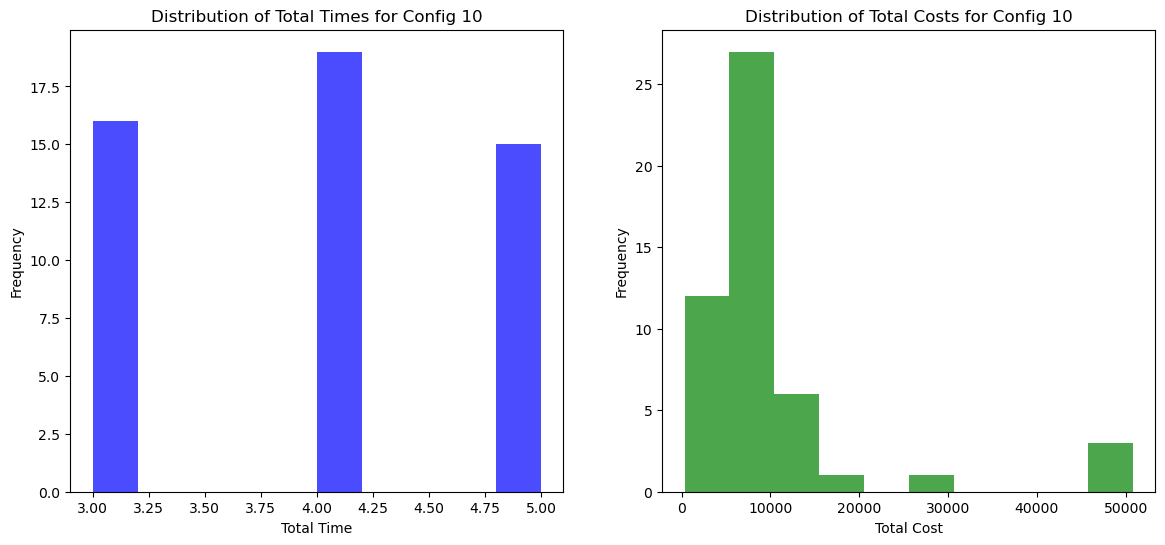


Best Configuration is Configuration 10: {'manufacturing_reduction': 9, 'distribution_reduction': 4} with Lowest Time: 3.98 and Cost: 9478.387800000002


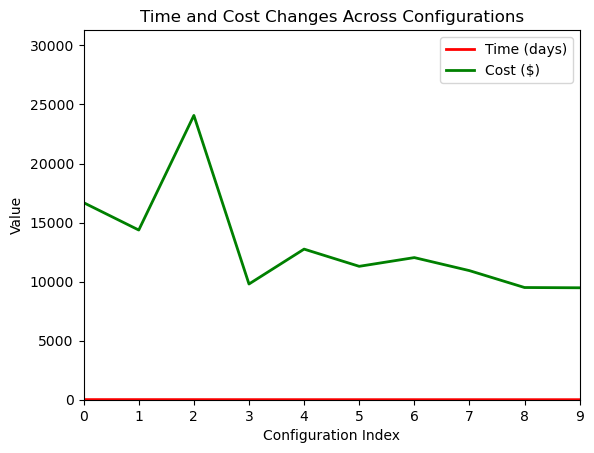

In [17]:
#MFG-598
#Project-1
#Yugeshwaran Gunasekar - 1230777186

import pandas as pd
import simpy
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

def CleanData(file_path):
    data = pd.read_csv(file_path)
    numeric_cols = ['Line Item Quantity', 'Line Item Value', 'Pack Price', 'Unit Price']
    data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')
    data['Freight Cost (USD)'] = pd.to_numeric(data['Freight Cost (USD)'], errors='coerce')
    for col in numeric_cols + ['Freight Cost (USD)']:
        median_val = data[col].median()
        data[col].fillna(median_val, inplace=True)
#     display(data)
    return data

def SimulationSetup(env, data, num_orders, config):
    results = []
    for i in range(num_orders):
        sample = data.sample(1).iloc[0]
        process = env.process(SuppyChainProcess(env, f'Order {i+1}', sample, config))
        results.append(process)
    return results

def SuppyChainProcess(env, name, sample, config):
    manufacturing_time = max(1, random.randint(1, 10) - config['manufacturing_reduction'])
    distribution_time = max(1, random.randint(1, 5) - config['distribution_reduction'])
    retail_time = random.randint(1, 3)

    yield env.timeout(manufacturing_time + distribution_time + retail_time)

    total_time = manufacturing_time + distribution_time + retail_time
    total_cost = sample['Freight Cost (USD)'] + sample['Unit Price'] * sample['Line Item Quantity']

    return (name, total_time, total_cost)

def Simulation(data, config):
    env = simpy.Environment()
    num_orders = 50
    results = SimulationSetup(env, data, num_orders, config)
    env.run()
    return [res.value for res in results]

def AnimateResults(config_times, config_costs):
    fig, ax = plt.subplots()
    line1, = ax.plot([], [], 'r-', label='Time (days)', lw=2)
    line2, = ax.plot([], [], 'g-', label='Cost ($)', lw=2)
    plt.legend()
    plt.title('Time and Cost Changes Across Configurations')
    plt.xlabel('Configuration Index')
    plt.ylabel('Value')

    def init():
        ax.set_xlim(0, len(config_times) - 1)
        ax.set_ylim(0, max(max(config_times), max(config_costs)) * 1.3)
        return line1, line2,

    def Update(frame):
        line1.set_data(range(frame + 1), config_times[:frame + 1])
        line2.set_data(range(frame + 1), config_costs[:frame + 1])
        return line1, line2,

    ani = FuncAnimation(fig, Update, frames=len(config_times), init_func=init, blit=True)
    return HTML(ani.to_jshtml())

def Configurations(data, num_configs):
    configurations = [{'manufacturing_reduction': i, 'distribution_reduction': i // 2} for i in range(num_configs)]
    times = []
    costs = []

    best_time = float('inf')
    best_cost = float('inf')
    best_config = None

    for i, config in enumerate(configurations):
        results = Simulation(data, config)
        if results:
            average_time = sum(res[1] for res in results) / len(results)
            average_cost = sum(res[2] for res in results) / len(results)
            times.append(average_time)
            costs.append(average_cost)
            print(f"Config {i+1}: {config}, Average Time: {average_time}, Average Cost: {average_cost}")
            
            plt.figure(figsize=(14, 6))
            plt.subplot(1, 2, 1)
            plt.hist([res[1] for res in results], bins=10, color='blue', alpha=0.7)
            plt.title(f'Distribution of Total Times for Config {i+1}')
            plt.xlabel('Total Time')
            plt.ylabel('Frequency')

            plt.subplot(1, 2, 2)
            plt.hist([res[2] for res in results], bins=10, color='green', alpha=0.7)
            plt.title(f'Distribution of Total Costs for Config {i+1}')
            plt.xlabel('Total Cost')
            plt.ylabel('Frequency')
            plt.show()
            
            if average_time < best_time and average_cost < best_cost:
                best_time = average_time
                best_cost = average_cost
                best_config = config
                best_config_no = i + 1

    animation = AnimateResults(times, costs)
    display(animation)
    print(f"\nBest Configuration is Configuration {best_config_no}: {best_config} with Lowest Time: {best_time} and Cost: {best_cost}")

def main(file_path):
    data = CleanData(file_path)
    num_configs = int(input("Enter the number of configurations to test: "))
    Configurations(data, num_configs)

if __name__ == '__main__':
    file_path = "C:/Users/yuges/Downloads/SCMS_Delivery_History_Dataset.csv" 
    main(file_path)